In [1]:
import sys
print(f'Interpreter dir: {sys.executable}')
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
print(f'Working dir: {os.getcwd()}')
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/GitHub/water_hackathlon/.venv_waterhack/bin/python3
Working dir: /Users/jsg/Documents/GitHub/water_hackathlon


In [2]:
import glob
from pathlib import Path
    
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

from waterhack.utils import find_col

# Load smart meter data

For every timestamp, calculate:
- Sum of consumption
- sd and other statistics
- Keep the info from the DMA

---

In [3]:
df_attrib = pd.read_excel("data/raw/AWSmartMeterAttributes.xlsx")
df_attrib.columns
df_attrib

,Unique Ref,DMASHORTNAME,Bill Class grouping,City,Post Code,Meter Location,My Use Registered,My Use Registered date,My Use contacted
0,01E91FB9-C6CA-43D6-8AB2-4724B8E183AA,NEWCENMA,Measured Domestic,NEWMARKET,CB8 9,External,No,NaT,Yes
1,025CC02F-2F7C-4547-B6F7-2305EEAD6E98,NEWCENMA,Commercial,NEWMARKET,CB8 9,External,No,NaT,Yes
2,02ABC9EA-DCAC-4D24-893E-DC242E4BC07F,NEWCENMA,Measured Domestic,NEWMARKET,CB8 9,External,No,NaT,NaN
3,02B6D30E-C99D-4E59-9C5F-0900F7255CE2,NEWCENMA,Measured Domestic,NEWMARKET,CB8 9,External,No,NaT,Yes
4,030FC39D-D3FB-489C-A03A-378C97AE5F9D,NEWCENMA,Measured Domestic,NEWMARKET,CB8 9,External,No,NaT,NaN
...,...,...,...,...,...,...,...,...,...
17637,81C249-s57P-513D-F431,NORFIFMA,Measured Domestic,NORWICH,NR6 7,External,No,NaT,NaN
17638,86I255-y24P-956H-W337,NORW21MA,Measured Domestic,NORWICH,NR6 7,External,No,NaT,NaN
17639,89B266-a57L-226G-Y469,NaN,NaN,NORWICH,NR6 7,Internal,No,NaT,NaN
17640,92B222-209E-581B-G031,NORFIFMA,Measured Domestic,NORWICH,NR6 7,External,No,NaT,NaN


In [4]:
df_attrib.DMASHORTNAME.value_counts()

NORW21MA    3341
NEWSEVMA    2815
NEWCENMA    2626
NORFIFMA    1817
BLOFLDMA    1371
NORW37MA    1359
NORCRDMA    1076
NORW18MA    1014
NEWSTUMA     921
SWALSHMA     607
BURYRDMA      51
Name: DMASHORTNAME, dtype: int64

In [5]:
df_attrib['Unique Ref'].nunique()

17534

In [47]:
file_list = list(Path('data/raw/SmartMeter/').rglob('*.txt'))
file_list

[PosixPath('data/raw/SmartMeter/SmartMetermar2020.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterJul2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterFeb2020.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterNov2017.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterJune2017.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterFeb2019.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterApril2019.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterFeb2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterApril2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterJan2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterMay2019.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterAug2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterAug2019.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterMay2018.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterJan2019.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterOct2017.txt'),
 PosixPath('data/raw/SmartMeter/SmartMeterJuly2019.txt'),
 PosixPath('data/raw/Smar

In [76]:
def process_file(f,df_attrib):
    # Load file
    df_file = pd.read_csv(f, parse_dates=['DateTime'])
    
    # Merge with DMA info
    df_m = pd.merge(df_attrib[['DMASHORTNAME','Unique Ref','Bill Class grouping']], df_file,left_on='Unique Ref',right_on='UniqueReference')
    
    # Aggregate
    df_agg = df_m.groupby(['DateTime','DMASHORTNAME','Bill Class grouping']).agg({'Consumption':['sum','mean','max','min','std'],})
    
    # Fix columns
    df = df_agg.reset_index()
    df.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in df.columns]
    
    return df

process_file(file_list[0],df_attrib)

,DateTime,DMASHORTNAME,Bill Class grouping,Consumption_sum,Consumption_mean,Consumption_max,Consumption_min,Consumption_std
0,2020-03-01,BLOFLDMA,Commercial,984,27.333333,278548,-278545,94165.935414
1,2020-03-01,BLOFLDMA,Measured Domestic,6805,5.856282,203291,-203284,17337.480706
2,2020-03-01,BLOFLDMA,Unmeasured Domestic,1181,10.359649,95,0,16.202331
3,2020-03-01,BURYRDMA,Commercial,270,33.750000,255,0,89.552459
4,2020-03-01,BURYRDMA,Measured Domestic,223,4.955556,313326,-313318,94470.137890
...,...,...,...,...,...,...,...,...
24580,2020-04-01,NORW37MA,Measured Domestic,2478,2.344371,65,0,5.710557
24581,2020-04-01,NORW37MA,Unmeasured Domestic,803,5.050314,128,0,14.551871
24582,2020-04-01,SWALSHMA,Commercial,441,10.756098,130,0,29.027384
24583,2020-04-01,SWALSHMA,Measured Domestic,1752,3.627329,341270,-341247,43200.296150


In [78]:
list_df = []
for i,f in enumerate(file_list):
    
    print(f"Processing file {f}, {i}/{len(file_list)}")
    df_file = process_file(f, df_attrib)

    # Append
    list_df.append(df_file)

Processing file data/raw/SmartMeter/SmartMetermar2020.txt, 0/44
Processing file data/raw/SmartMeter/SmartMeterJul2018.txt, 1/44
Processing file data/raw/SmartMeter/SmartMeterFeb2020.txt, 2/44
Processing file data/raw/SmartMeter/SmartMeterNov2017.txt, 3/44
Processing file data/raw/SmartMeter/SmartMeterJune2017.txt, 4/44
Processing file data/raw/SmartMeter/SmartMeterFeb2019.txt, 5/44
Processing file data/raw/SmartMeter/SmartMeterApril2019.txt, 6/44
Processing file data/raw/SmartMeter/SmartMeterFeb2018.txt, 7/44
Processing file data/raw/SmartMeter/SmartMeterApril2018.txt, 8/44
Processing file data/raw/SmartMeter/SmartMeterJan2018.txt, 9/44
Processing file data/raw/SmartMeter/SmartMeterMay2019.txt, 10/44
Processing file data/raw/SmartMeter/SmartMeterAug2018.txt, 11/44
Processing file data/raw/SmartMeter/SmartMeterAug2019.txt, 12/44
Processing file data/raw/SmartMeter/SmartMeterMay2018.txt, 13/44
Processing file data/raw/SmartMeter/SmartMeterJan2019.txt, 14/44
Processing file data/raw/Smart

In [79]:
df_all = pd.concat(list_df)
df_all = df_all.sort_values('DateTime')
df_all

,DateTime,DMASHORTNAME,Bill Class grouping,Consumption_sum,Consumption_mean,Consumption_max,Consumption_min,Consumption_std
0,2016-12-05 00:00:00,NEWCENMA,Measured Domestic,0,0.000000,0,0,0.000000
1,2016-12-05 00:00:00,NEWCENMA,Unmeasured Domestic,0,0.000000,0,0,NaN
2,2016-12-05 00:00:00,NEWSEVMA,Measured Domestic,0,0.000000,0,0,0.000000
3,2016-12-05 00:00:00,NEWSEVMA,Unmeasured Domestic,0,0.000000,0,0,NaN
6,2016-12-05 01:00:00,NEWCENMA,Measured Domestic,271,2.356522,25,0,5.049216
...,...,...,...,...,...,...,...,...
20606,2020-07-27 00:00:00,NEWSTUMA,Unmeasured Domestic,389,5.557143,86,0,11.696197
20607,2020-07-27 00:00:00,NORCRDMA,Commercial,240,21.818182,128,0,46.893109
20608,2020-07-27 00:00:00,NORCRDMA,Measured Domestic,1315,2.408425,74,0,6.735626
20598,2020-07-27 00:00:00,NEWCENMA,Commercial,2013,10.166667,1130,0,82.714833


In [80]:
df_all.to_csv('data/processed/smart_meter_aggregated_all.csv', index=False)

# Load a specific house data and visualize

Something is weird...

In [67]:
df_single = pd.read_csv('data/raw/SmartMeter/SmartMetermar2020.txt', parse_dates=['DateTime'])

In [69]:
df_single1 = df_single[df_single['UniqueReference'] == '86B59325-0E22-4FDF-AF03-4FE2881A1DC1']

In [71]:
df_single1.sort_values('DateTime').head(30)

,UniqueReference,DateTime,Consumption
4301958,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 00:00:00,-4989
4368249,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 00:00:00,0
4368248,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 00:00:00,4989
4301957,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 00:00:00,0
8815672,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 01:00:00,0
8822831,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 01:00:00,0
8822832,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 01:00:00,-4989
8815671,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 01:00:00,4989
4368359,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 02:00:00,13
4301995,86B59325-0E22-4FDF-AF03-4FE2881A1DC1,2020-03-01 02:00:00,-4976


<AxesSubplot:xlabel='DateTime', ylabel='Consumption'>

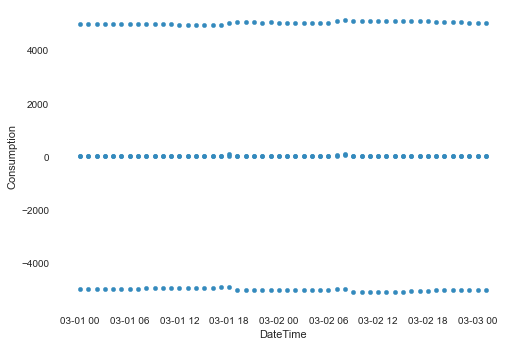

In [89]:
df_single1.sort_values('DateTime').head(200).plot.scatter('DateTime','Consumption')

#  Merge with DMA dataset

In [92]:
df_smart = pd.read_csv('data/processed/smart_meter_aggregated_all.csv', parse_dates=['DateTime'])
df_smart

,DateTime,DMASHORTNAME,Bill Class grouping,Consumption_sum,Consumption_mean,Consumption_max,Consumption_min,Consumption_std
0,2016-12-05 00:00:00,NEWCENMA,Measured Domestic,0,0.000000,0,0,0.000000
1,2016-12-05 00:00:00,NEWCENMA,Unmeasured Domestic,0,0.000000,0,0,NaN
2,2016-12-05 00:00:00,NEWSEVMA,Measured Domestic,0,0.000000,0,0,0.000000
3,2016-12-05 00:00:00,NEWSEVMA,Unmeasured Domestic,0,0.000000,0,0,NaN
4,2016-12-05 01:00:00,NEWCENMA,Measured Domestic,271,2.356522,25,0,5.049216
...,...,...,...,...,...,...,...,...
912882,2020-07-27 00:00:00,NEWSTUMA,Unmeasured Domestic,389,5.557143,86,0,11.696197
912883,2020-07-27 00:00:00,NORCRDMA,Commercial,240,21.818182,128,0,46.893109
912884,2020-07-27 00:00:00,NORCRDMA,Measured Domestic,1315,2.408425,74,0,6.735626
912885,2020-07-27 00:00:00,NEWCENMA,Commercial,2013,10.166667,1130,0,82.714833


In [98]:
df_smart_h = df_smart.groupby(['DateTime','DMASHORTNAME'])['Consumption_sum'].sum().reset_index()
df_smart_h

,DateTime,DMASHORTNAME,Consumption_sum
0,2016-12-05 00:00:00,NEWCENMA,0
1,2016-12-05 00:00:00,NEWSEVMA,0
2,2016-12-05 01:00:00,BURYRDMA,31
3,2016-12-05 01:00:00,NEWCENMA,302
4,2016-12-05 01:00:00,NEWSEVMA,844
...,...,...,...
320446,2020-07-27 00:00:00,NORFIFMA,3988
320447,2020-07-27 00:00:00,NORW18MA,2937
320448,2020-07-27 00:00:00,NORW21MA,7355
320449,2020-07-27 00:00:00,NORW37MA,2112


In [114]:
df_dma = pd.read_csv('data/processed/DMAVolumePressureWeather.csv', sep=",",parse_dates = ['Timestamp','DateRaised'])
df_dma

,DMA,Timestamp,PressureBar,m3Volume,DateRaised,LeakType,DMAName,is_leakage,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,DewPointC,humidity,precipMM,pressure,tempC
0,NEWSEVMA,2016-12-01,2.011256,11.210,NaT,NaN,NaN,0,7,3,0.0,6.8,2,3,95,0.0,1031,4
1,NORW21MA,2016-12-01,2.345946,8.094,NaT,NaN,NaN,0,7,3,0.0,6.8,2,3,95,0.0,1031,4
2,NEWSTUMA,2016-12-01,2.564902,0.000,NaT,NaN,NaN,0,7,3,0.0,6.8,2,3,95,0.0,1031,4
3,BURYRDMA,2016-12-01,2.208337,2.650,NaT,NaN,NaN,0,7,3,0.0,6.8,2,3,95,0.0,1031,4
4,NORW37MA,2016-12-01,2.514855,2.791,NaT,NaN,NaN,0,7,3,0.0,6.8,2,3,95,0.0,1031,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943663,NORFIFMA,2020-06-01,0.000000,3.375,NaT,NaN,NaN,0,18,10,0.0,16.7,5,10,95,0.0,1026,10
943664,NORCRDMA,2020-06-01,1.698159,2.077,NaT,NaN,NaN,0,18,10,0.0,16.7,5,10,95,0.0,1026,10
943665,NEWSTUMA,2020-06-01,2.667152,2.300,NaT,NaN,NaN,0,18,10,0.0,16.7,5,10,95,0.0,1026,10
943666,NORW37MA,2020-06-01,2.570253,1.598,NaT,NaN,NaN,0,18,10,0.0,16.7,5,10,95,0.0,1026,10


In [178]:
avg_cols = [ 'PressureBar', 'is_leakage', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'DewPointC', 'humidity', 'precipMM', 'pressure',
       'tempC']

d_agg = {}
for a in avg_cols:
    d_agg[a] = 'mean'
d_agg['m3Volume'] = 'sum'
d_agg

{'PressureBar': 'mean',
 'is_leakage': 'mean',
 'maxtempC': 'mean',
 'mintempC': 'mean',
 'totalSnow_cm': 'mean',
 'sunHour': 'mean',
 'uvIndex': 'mean',
 'DewPointC': 'mean',
 'humidity': 'mean',
 'precipMM': 'mean',
 'pressure': 'mean',
 'tempC': 'mean',
 'm3Volume': 'sum'}

In [179]:
df_dma['Timestamp_datehour'] = df_dma['Timestamp'].dt.floor('H')

In [180]:
df_dma_h = df_dma.groupby(['DMA', 'Timestamp_datehour']).agg(d_agg)
df_dma_h = df_dma_h.reset_index()
df_dma_h['is_leakage']= np.where(df_dma_h['is_leakage'] > 0,1, 0)
df_dma_h

,DMA,Timestamp_datehour,PressureBar,is_leakage,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,DewPointC,humidity,precipMM,pressure,tempC,m3Volume
0,BLOFLDMA,2019-03-25 00:00:00,4.890933,0,9.00,5.0,0.0,7.7,3.0,1.75,75.75,0.0,1026.75,5.75,12.970001
1,BLOFLDMA,2019-03-25 01:00:00,4.890933,0,9.00,5.0,0.0,7.7,3.0,1.00,74.75,0.0,1026.00,5.00,11.330001
2,BLOFLDMA,2019-03-25 02:00:00,4.400614,0,9.00,5.0,0.0,7.7,3.0,1.00,73.75,0.0,1025.75,5.00,10.560000
3,BLOFLDMA,2019-03-25 03:00:00,4.241261,0,9.00,5.0,0.0,7.7,3.0,1.00,73.00,0.0,1025.25,5.00,9.650000
4,BLOFLDMA,2019-03-25 04:00:00,4.841901,0,9.00,5.0,0.0,7.7,3.0,0.75,73.00,0.0,1026.00,5.00,10.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235989,SWALSHMA,2020-05-31 20:00:00,0.000000,0,19.00,10.0,0.0,16.7,5.0,9.00,85.75,0.0,1025.25,11.75,0.000000
235990,SWALSHMA,2020-05-31 21:00:00,0.000000,0,19.00,10.0,0.0,16.7,5.0,9.00,91.25,0.0,1026.00,11.00,0.000000
235991,SWALSHMA,2020-05-31 22:00:00,0.000000,0,19.00,10.0,0.0,16.7,5.0,9.00,92.50,0.0,1026.00,10.75,0.000000
235992,SWALSHMA,2020-05-31 23:00:00,0.000000,0,18.75,10.0,0.0,16.7,5.0,9.25,94.25,0.0,1026.00,10.00,0.000000


In [181]:
df_merge = pd.merge(df_smart_h,df_dma_h,
                    left_on=['DMASHORTNAME','DateTime'], right_on=['DMA','Timestamp_datehour'])
print(f"Shape df_smart_h:{df_smart_h.shape} Shape df_dma_h: {df_dma_h.shape} Shape result df_merge: {df_merge.shape}")

df_merge = df_merge.drop(['Timestamp_datehour','DMASHORTNAME'],axis=1)
df_merge

Shape df_smart_h:(320451, 3) Shape df_dma_h: (235994, 15) Shape result df_merge: (213865, 18)


,DateTime,Consumption_sum,DMA,PressureBar,is_leakage,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,DewPointC,humidity,precipMM,pressure,tempC,m3Volume
0,2016-12-05 00:00:00,0,NEWCENMA,3.205348,0,7.0,4.0,0.0,3.0,2.0,0.00,77.25,0.0,1025.0,4.0,43.890
1,2016-12-05 00:00:00,0,NEWSEVMA,2.030805,0,7.0,4.0,0.0,3.0,2.0,0.00,77.25,0.0,1025.0,4.0,42.040
2,2016-12-05 01:00:00,31,BURYRDMA,2.375682,0,7.0,4.0,0.0,3.0,2.0,0.25,78.25,0.0,1025.0,4.0,3.300
3,2016-12-05 01:00:00,302,NEWCENMA,3.228025,0,7.0,4.0,0.0,3.0,2.0,0.25,78.25,0.0,1025.0,4.0,39.060
4,2016-12-05 01:00:00,844,NEWSEVMA,1.940877,0,7.0,4.0,0.0,3.0,2.0,0.25,78.25,0.0,1025.0,4.0,36.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213860,2020-06-01 00:00:00,14704,NORFIFMA,0.000000,0,18.0,10.0,0.0,16.7,5.0,10.00,95.00,0.0,1026.0,10.0,3.375
213861,2020-06-01 00:00:00,10536,NORW18MA,0.000000,0,18.0,10.0,0.0,16.7,5.0,10.00,95.00,0.0,1026.0,10.0,0.000
213862,2020-06-01 00:00:00,22104,NORW21MA,2.352202,0,18.0,10.0,0.0,16.7,5.0,10.00,95.00,0.0,1026.0,10.0,1.025
213863,2020-06-01 00:00:00,10714,NORW37MA,2.570253,0,18.0,10.0,0.0,16.7,5.0,10.00,95.00,0.0,1026.0,10.0,1.598


# Visualize input flow and consumption

/Users/jsg/Documents/GitHub/water_hackathlon/.venv_waterhack/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



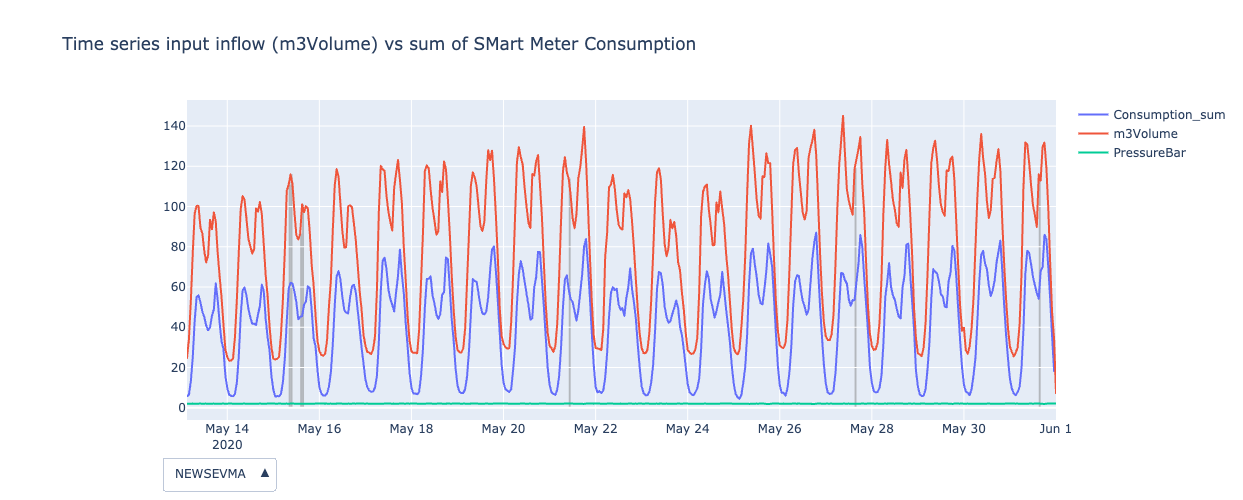

In [184]:
from waterhack.visualize import time_vs_y

df_plot = df_merge.tail(5000)
df_plot['Consumption_sum'] = df_plot['Consumption_sum']/1000

fig = time_vs_y(df = df_plot,
          time_col = 'DateTime',
         id_col_name = 'DMA',
         id_list =['NEWSEVMA', 'NORW21MA', 'NEWSTUMA', 'BURYRDMA', 'NORW37MA',
       'NEWCENMA', 'NORFIFMA', 'SWALSHMA', 'NORW18MA', 'NORCRDMA',
       'BLOFLDMA'],
         cols_descr = ['Consumption_sum','m3Volume','PressureBar'],
          y_col = 'is_leakage',
         title='Time series input inflow (m3Volume) vs sum of SMart Meter Consumption')

fig


In [183]:
fig.write_html("./data/figures/time_series_smartmeter_vs_inflow.html")